###  MicroGrad demo

In [43]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
from cugrad.tensor import Tensor
from cugrad.nn import Neuron, Layer, MLP

In [45]:
np.random.seed(1337)
random.seed(1337)

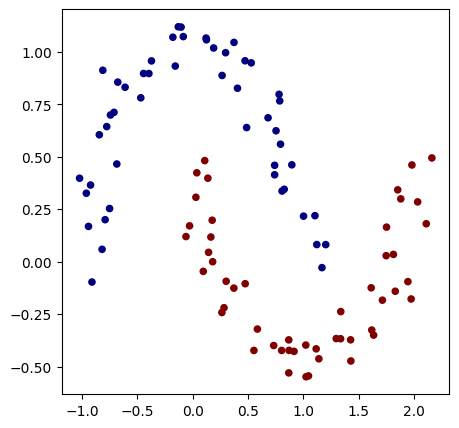

In [46]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [47]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))
print(model.parameters())

number of parameters 337
[<cugrad.tensor.Tensor object at 0x706b829d08f0>, <cugrad.tensor.Tensor object at 0x706b829d30f0>, <cugrad.tensor.Tensor object at 0x706b829d37b0>, <cugrad.tensor.Tensor object at 0x706b829d15f0>, <cugrad.tensor.Tensor object at 0x706b829d1430>, <cugrad.tensor.Tensor object at 0x706b829d2a70>, <cugrad.tensor.Tensor object at 0x706b829d0d30>, <cugrad.tensor.Tensor object at 0x706b829d0b70>, <cugrad.tensor.Tensor object at 0x706b829d38f0>, <cugrad.tensor.Tensor object at 0x706b829d31f0>, <cugrad.tensor.Tensor object at 0x706b829d06f0>, <cugrad.tensor.Tensor object at 0x706b829d01b0>, <cugrad.tensor.Tensor object at 0x706b829d3bb0>, <cugrad.tensor.Tensor object at 0x706b829d2ef0>, <cugrad.tensor.Tensor object at 0x706b829d0170>, <cugrad.tensor.Tensor object at 0x706b829d1bf0>, <cugrad.tensor.Tensor object at 0x706b829d38b0>, <cugrad.tensor.Tensor object at 0x706b829d15b0>, <cugrad.tensor.Tensor object at 0x706b829deaf0>, <cugrad.tensor.Tensor object at 0x706b829dc

In [48]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Tensor, xrow)) for xrow in Xb]
    # forward the model to get scores
    scores = list(map(model, inputs))
    for s in scores:
        print(s[0].data)
    # svm "max-margin" loss
    losses = [(Tensor(1.0) + Tensor(-1.0) * Tensor(yi)*scorei[0]).relu() for yi, scorei in zip(yb, scores)]
    def tensor_sum(tensors):
        x = tensors[0]
        for i in range(1, len(tensors)):
            x = x + tensors[i]
        return x
    sm = tensor_sum(losses)
    data_loss = sm * Tensor((1.0 / len(losses)))
    # L2 regularization
    alpha = 1e-4
    reg_loss = Tensor(alpha) * tensor_sum(list((p*p for p in model.parameters())))
    total_loss = data_loss + reg_loss

    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei[0].data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

0.22246646881103516
-0.31988924741744995
0.6796103715896606
0.6473433971405029
-0.32632309198379517
-0.2119060754776001
0.21443277597427368
-0.455325722694397
0.8936727046966553
-0.04153174161911011
0.11977505683898926
1.2621712684631348
1.4800999164581299
0.42175358533859253
-0.08332043886184692
-0.19491028785705566
-0.4842972755432129
0.13755610585212708
1.2529339790344238
0.5602155923843384
-0.2813071608543396
-0.44682514667510986
-0.5346472263336182
-0.4312840700149536
-0.05197387933731079
1.208790898323059
1.008969783782959
1.2313628196716309
-0.06803017854690552
-0.013529777526855469
1.3951761722564697
-0.16539615392684937
1.122711181640625
0.2676578760147095
0.10633450746536255
-0.7395278215408325
0.03370043635368347
-0.3454235792160034
-0.5547720193862915
0.2220253348350525
0.32676732540130615
1.1275880336761475
-0.13723301887512207
-0.2625123858451843
1.053966999053955
-0.4650103449821472
-0.4373994469642639
1.2308251857757568
-0.3009415864944458
-0.07934713363647461
0.1022836

In [49]:

def draw_compute_graph(tensor, filename="compute_graph", format="png"):
    import graphviz
    import itertools

    dot = graphviz.Digraph(format=format)
    dot.attr(rankdir='LR', size='12,12')

    # Unique identifier generator
    uid = itertools.count()

    # Mapping from tensor id to node name to avoid duplicates
    tensor_id_to_node = {}
    op_id_to_node = {}

    # Define colors for different operations
    op_colors = {
        "Add": "lightblue",
        "Subtract": "lightgreen",
        "Multiply": "orange",
        "Divide": "pink",
        "Exp": "yellow",
        "Tanh": "purple",
        # Add more operations and colors as needed
    }

    def add_nodes(tensor):
        if id(tensor) in tensor_id_to_node:
            return

        current_id = next(uid)
        tensor_node = f"tensor_{current_id}"
        tensor_id_to_node[id(tensor)] = tensor_node

        # Node label includes label, data, grad
        label = f"{tensor.label}\nData: {tensor.data:.2f}\nGrad: {tensor.grad:.2f}"
        dot.node(tensor_node, label=label, shape='ellipse')

        if tensor.op:
            # Create an operation node
            op = tensor.op
            op_node = f"op_{next(uid)}"
            op_id_to_node[id(op)] = op_node
            op_label = op.op_type
            color = op_colors.get(op_label, "gray")  # Default color if op_type not found
            dot.node(op_node, label=op_label, shape='box', style='filled', fillcolor=color)

            # Connect operation to tensor
            dot.edge(op_node, tensor_node)

            # Connect child tensors to operation
            for child in tensor.children:
                add_nodes(child)
                child_node = tensor_id_to_node[id(child)]
                dot.edge(child_node, op_node)

    add_nodes(tensor)
    dot.attr(rankdir='LR', size='50,50', ratio='compress')  # Adjust size and ratio
    dot.attr(dpi='1000')  # Increase resolution for clarity
    dot.render(filename, view=True)
    print(f"Computation graph saved as {filename}.{format}")

# draw_compute_graph(total_loss, "compute_graph_loss", "png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.65534 to fit


Computation graph saved as compute_graph_loss.png


In [ ]:
# optimization
for k in range(10):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


0.22246646881103516
-0.31988924741744995
0.6796103715896606
0.6473433971405029
-0.32632309198379517
-0.2119060754776001
0.21443277597427368
-0.455325722694397
0.8936727046966553
-0.04153174161911011
0.11977505683898926
1.2621712684631348
1.4800999164581299
0.42175358533859253
-0.08332043886184692
-0.19491028785705566
-0.4842972755432129
0.13755610585212708
1.2529339790344238
0.5602155923843384
-0.2813071608543396
-0.44682514667510986
-0.5346472263336182
-0.4312840700149536
-0.05197387933731079
1.208790898323059
1.008969783782959
1.2313628196716309
-0.06803017854690552
-0.013529777526855469
1.3951761722564697
-0.16539615392684937
1.122711181640625
0.2676578760147095
0.10633450746536255
-0.7395278215408325
0.03370043635368347
-0.3454235792160034
-0.5547720193862915
0.2220253348350525
0.32676732540130615
1.1275880336761475
-0.13723301887512207
-0.2625123858451843
1.053966999053955
-0.4650103449821472
-0.4373994469642639
1.2308251857757568
-0.3009415864944458
-0.07934713363647461
0.1022836

In [34]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


NameError: name 'Value' is not defined